<a href="https://colab.research.google.com/github/solharsh/QwikLabs_AWS_Case_Study/blob/master/cust_churn_cutoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn Prediction with XGBoost

Using Gradient Boosted Trees to Predict Mobile Customer Departure

#Background

Losing customers is costly for any business. Identifying unhappy customers early on gives you a chance to offer them incentives to stay. This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us–leaving a mobile phone operator. Seems like I can always find fault with my provider! And if my provider knows that I’m thinking of leaving, it can offer timely incentives–I can always use a phone upgrade or perhaps have a new feature activated–and I might just stick around. Incentives are often much more cost effective than losing and reacquiring a customer.


In [0]:
#below code can be ignore as it was used while working on Sagemaker
#bucket = '<your_s3_bucket_name_here>'
#prefix = 'sagemaker/DEMO-xgboost-churn'

# Define IAM role
#import boto3
#import re
#from sagemaker import get_execution_role

#role = get_execution_role()

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime

---
## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets. 

[Link to download data](http://dataminingconsultant.com/DKD2e_data_sets.zip)

In [4]:
!unzip -o DKD2e_data_sets.zip

Archive:  DKD2e_data_sets.zip
 extracting: Data sets/adult.zip     
  inflating: Data sets/cars.txt      
  inflating: Data sets/cars2.txt     
  inflating: Data sets/cereals.CSV   
  inflating: Data sets/churn.txt     
  inflating: Data sets/ClassifyRisk  
  inflating: Data sets/ClassifyRisk - Missing.txt  
 extracting: Data sets/DKD2e data sets.zip  
  inflating: Data sets/nn1.txt       


In [6]:
churn = pd.read_csv('/content/churn.txt')
pd.set_option('display.max_columns', 500)
churn

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False.
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False.
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False.
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False.


By modern standards, it’s a relatively small dataset, with only 3,333 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: presumably the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute–the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:

col_0,% observations
State,
AK,0.015602
AL,0.024002
AR,0.016502
AZ,0.019202
CA,0.010201
CO,0.019802
CT,0.022202
DC,0.016202
DE,0.018302


col_0,% observations
Phone,
327-1058,0.0003
327-1319,0.0003
327-3053,0.0003
327-3587,0.0003
327-3850,0.0003
...,...
422-7728,0.0003
422-8268,0.0003
422-8333,0.0003


col_0,% observations
Int'l Plan,
no,0.90309
yes,0.09691


col_0,% observations
VMail Plan,
no,0.723372
yes,0.276628


col_0,% observations
Churn?,
False.,0.855086
True.,0.144914


,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


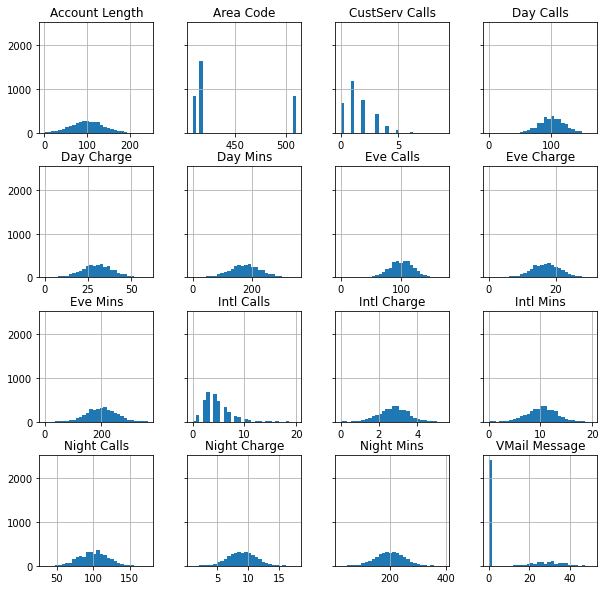

In [7]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

We can see immediately that:

- State appears to be quite evenly distributed
- Phone takes on too many unique values to be of any practical use. It's possible parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.
- Only 14% of customers churned, so there is some class imabalance, but nothing extreme.
- Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity. VMail Message being a notable exception (and Area Code showing up as a feature we should convert to non-numeric).


In [0]:
churn = churn.drop('Phone', axis=1)
churn['Area Code'] = churn['Area Code'].astype(object)

Next let's look at the relationship between each of the features and our target variable.

Churn?,False.,True.
State,,
AK,0.017193,0.006211
AL,0.025263,0.016563
AR,0.015439,0.022774
AZ,0.021053,0.008282
CA,0.008772,0.018634
CO,0.020000,0.018634
CT,0.021754,0.024845
DC,0.017193,0.010352
DE,0.018246,0.018634


Churn?,False.,True.
Area Code,,
408,0.251228,0.252588
415,0.497895,0.488613
510,0.250877,0.258799


Churn?,False.,True.
Int'l Plan,,
no,0.934737,0.716356
yes,0.065263,0.283644


Churn?,False.,True.
VMail Plan,,
no,0.704561,0.834369
yes,0.295439,0.165631


Account Length


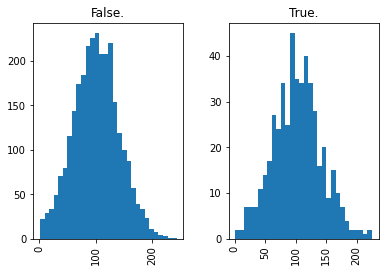

VMail Message


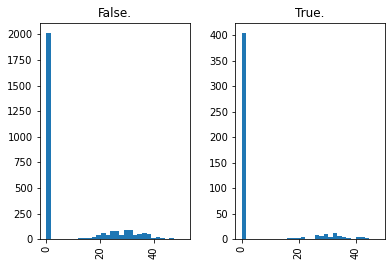

Day Mins


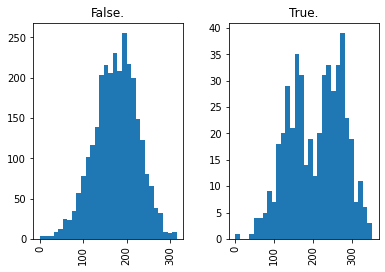

Day Calls


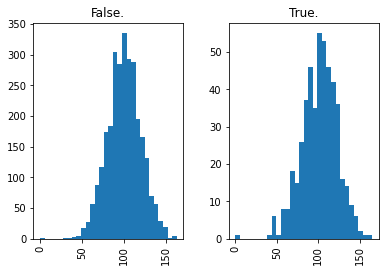

Day Charge


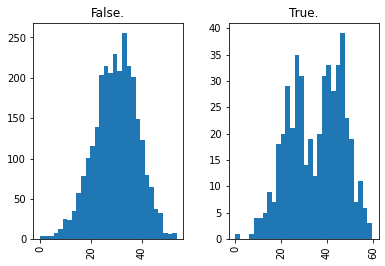

Eve Mins


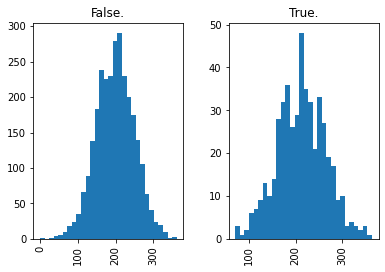

Eve Calls


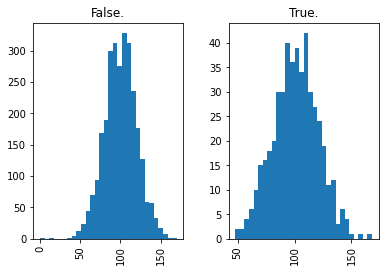

Eve Charge


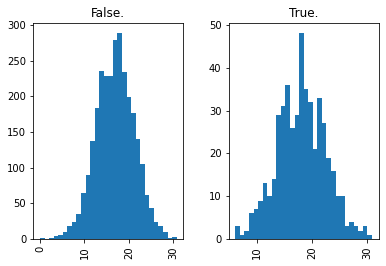

Night Mins


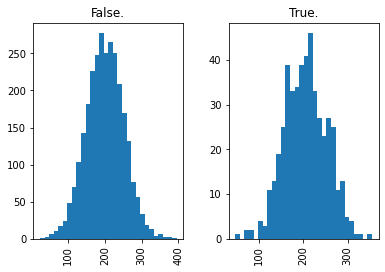

Night Calls


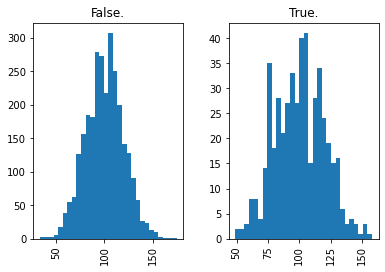

Night Charge


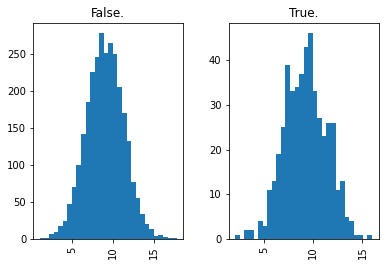

Intl Mins


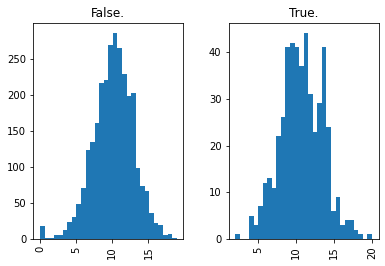

Intl Calls


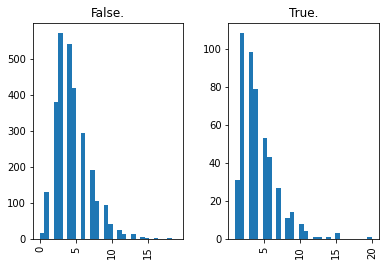

Intl Charge


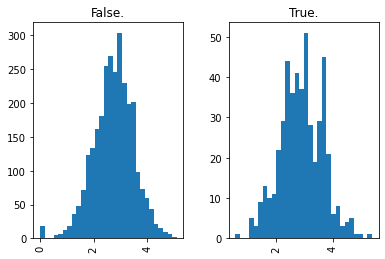

CustServ Calls


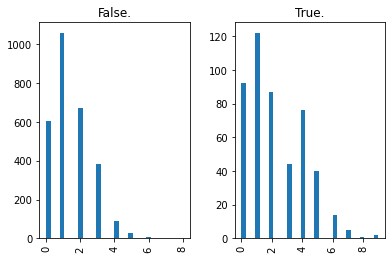

In [9]:
for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        display(pd.crosstab(index=churn[column], columns=churn['Churn?'], normalize='columns'))

for column in churn.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = churn[[column, 'Churn?']].hist(by='Churn?', bins=30)
    plt.show()  

Interestingly we see that churners appear:

- Fairly evenly distributed geographically
- More likely to have an international plan
- Less likely to have a voicemail plan
- To exhibit some bimodality in daily minutes (either higher or lower than the average for non-churners)
- To have a larger number of customer service calls (which makes sense as we'd expect customers who experience lots of problems may be more likely to churn)

In addition, we see that churners take on very similar distributions for features like Day Mins and Day Charge. That's not surprising as we'd expect minutes spent talking to correlate with charges. Let's dig deeper into the relationships between our features.


,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796
VMail Message,-0.004628,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263
Day Mins,0.006216,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423
Day Calls,0.038470,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942
Day Charge,0.006214,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427
Eve Mins,-0.006757,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985
Eve Calls,0.019260,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423
Eve Charge,-0.006745,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987
Night Mins,-0.008955,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288
Night Calls,-0.013176,0.007123,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,0.011188,-0.013605,0.000305,-0.013630,-0.012802


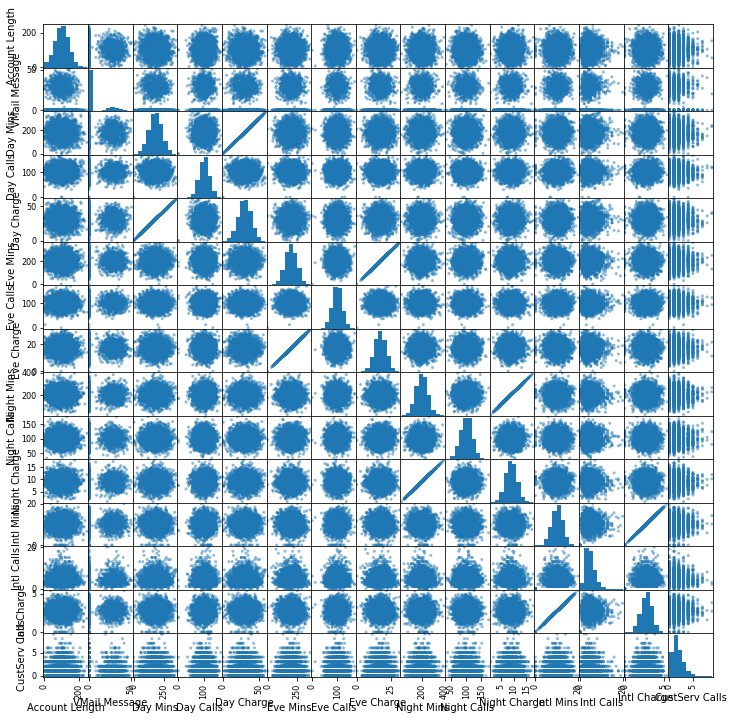

In [10]:
display(churn.corr())
pd.plotting.scatter_matrix(churn, figsize=(12, 12))
plt.show()

We see several features that essentially have 100% correlation with one another. Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias. Let's remove one feature from each of the highly correlated pairs: Day Charge from the pair with Day Mins, Night Charge from the pair with Night Mins, Intl Charge from the pair with Intl Mins:

In [0]:
churn = churn.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)

Now that we've cleaned up our dataset, let's determine which algorithm to use.  As mentioned above, there appear to be some variables where both high and low (but not intermediate) values are predictive of churn.  In order to accommodate this in an algorithm like linear regression, we'd need to generate polynomial (or bucketed) terms.  Instead, let's attempt to model this problem using gradient boosted trees.  Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint.  XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
- Have the predictor variable in the first column
- Not have a header row

But first, let's convert our categorical features into numeric features.

The beauty of this powerful algorithm lies in its scalability, which drives fast learning through parallel and distributed computing and offers efficient memory usage.

In [0]:
model_data = pd.get_dummies(churn)
model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)

In [34]:
model_data.head()

,Churn?_True.,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area Code_408,Area Code_415,Area Code_510,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
0,0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
1,0,107,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
2,0,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3,0,84,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
4,0,75,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0


And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [0]:
# importing required libraries
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [0]:
X, Y = np.split(model_data.sample(frac=1, random_state=1729), [int(0.8 * len(model_data))])

In [0]:
# read xTrainthe train and test dataset
train_data = pd.read_csv('/content/train.csv')
val_data = pd.read_csv('/content/validation.csv')

In [27]:
# shape of the dataset
print('Shape of training data :',train_data.shape)
print('Shape of testing data :',val_data.shape)

Shape of training data : (2332, 70)
Shape of testing data : (665, 70)


In [0]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(model_data.drop(['Churn?_True.'],axis=1), model_data['Churn?_True.'], test_size=test_size, random_state=seed)

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters. A few key hyperparameters are:
- max_depth controls how deep each tree within the algorithm can be built. Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting. There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- subsample controls sampling of the training data. This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- num_round controls the number of boosting rounds. This is essentially the subsequent models that are trained using the residuals of previous iterations. Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- eta controls how aggressive each round of boosting is. Larger values lead to more conservative boosting.
- gamma controls how aggressively trees are grown. Larger values lead to more conservative models.


In [66]:
xgb = XGBClassifier(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)
xgb.fit(X_train, y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=4,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=6, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_round=100, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=0, subsample=0.8, verbosity=1)

In [0]:
# make predictions for test data
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

In [70]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.45%


Relative cost of errors

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with and might even be solvable with simple rules instead of ML.

More important, if I put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. I also need to look at similar costs associated with correct predictions of true positives and true negatives. Because the choice of the cutoff affects all four of these statistics, I need to consider the relative costs to the business for each of these four outcomes for each prediction.

Assigning costs

What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the true negatives the cost of $0. Our model essentially correctly identified a happy customer in this case, and we don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the purposes of this example, let's assume $ 
$500. This is the cost of false negatives.

Finally, for customers that our model identifies as churning, let's assume a retention incentive in the amount of $ 
$100. If my provider offered me such a concession, I’d certainly think twice before leaving. This is the cost of both true positive and false positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will “waste” the $ 
$
100 concession. We probably could have spent that $ 
$
100 more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.


Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:
$500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP. We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs. 


Extensions

This notebook showcased how to build a model that predicts whether a customer is likely to churn, and then how to optimally set a threshold that accounts for the cost of true positives, false positives, and false negatives. There are several means of extending it including:
- Some customers who receive retention incentives will still churn. Including a probability of churning despite receiving an incentive in our cost function would provide a better ROI on our retention programs.
- Customers who switch to a lower-priced plan or who deactivate a paid feature represent different kinds of churn that could be modeled separately.
- Modeling the evolution of customer behavior. If usage is dropping and the number of calls placed to Customer Service is increasing, you are more likely to experience churn then if the trend is the opposite. A customer profile should incorporate behavior trends.
- Actual training data and monetary cost assignments could be more complex.
- Multiple models for each type of churn could be needed.

Regardless of additional complexity, similar principles described in this notebook are likely apply.
